<a href="https://colab.research.google.com/github/kimdonggyu2008/music_generation/blob/main/melody_generation_markov_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from music21 import *
import numpy as np

!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

!sh -e /etc/init.d/x11-common start

import os
os.putenv('DISPLAY', ':99.0')

!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

Repository: 'deb https://ppa.launchpadcontent.net/mscore-ubuntu/mscore-stable/ubuntu/ jammy main'
Description:
~~~~~~~~~ MUSESCORE 2 RELEASES FOR UBUNTU 12.04 AND LATER ~~~~~~~~~
Note that Canonical doesn’t allow new builds for releases marked obsolete
(any nōn-LTS predating the previous LTS (currently 24.04 “noble”), and any LTS
older than 7 years, currently anything before 14.04 “trusty”). The packages
for those older releases here can no longer be updated but still work, within
limitations. Best to upgrade to a supported release of the operating system!

INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore-stable
  sudo apt-get update
  sudo apt-get install musescore

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon 18.04 (bionic)”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.
⚠ KDE neon 18.04 was discontinued so those packages can no longer be updated

[('C5', 2), ('G5', 1), ('G5', 1), ('A5', 1), ('G5', 2), ('F5', 1), ('F5', 1), ('E5', 1), ('D5', 1), ('D5', 1), ('C5', 2), ('D5', 1), ('C5', 2), ('A5', 1), ('G5', 2), ('F5', 1), ('F5', 1), ('E5', 1), ('E5', 1), ('D5', 1), ('C5', 2), ('G5', 1), ('G5', 1), ('A5', 1), ('A5', 1), ('G5', 2), ('F5', 1), ('F5', 1), ('E5', 1), ('E5', 1), ('E5', 1), ('D5', 1), ('C5', 2), ('G5', 2), ('F5', 1), ('F5', 1), ('F5', 1), ('E5', 1), ('D5', 1), ('D5', 1)]


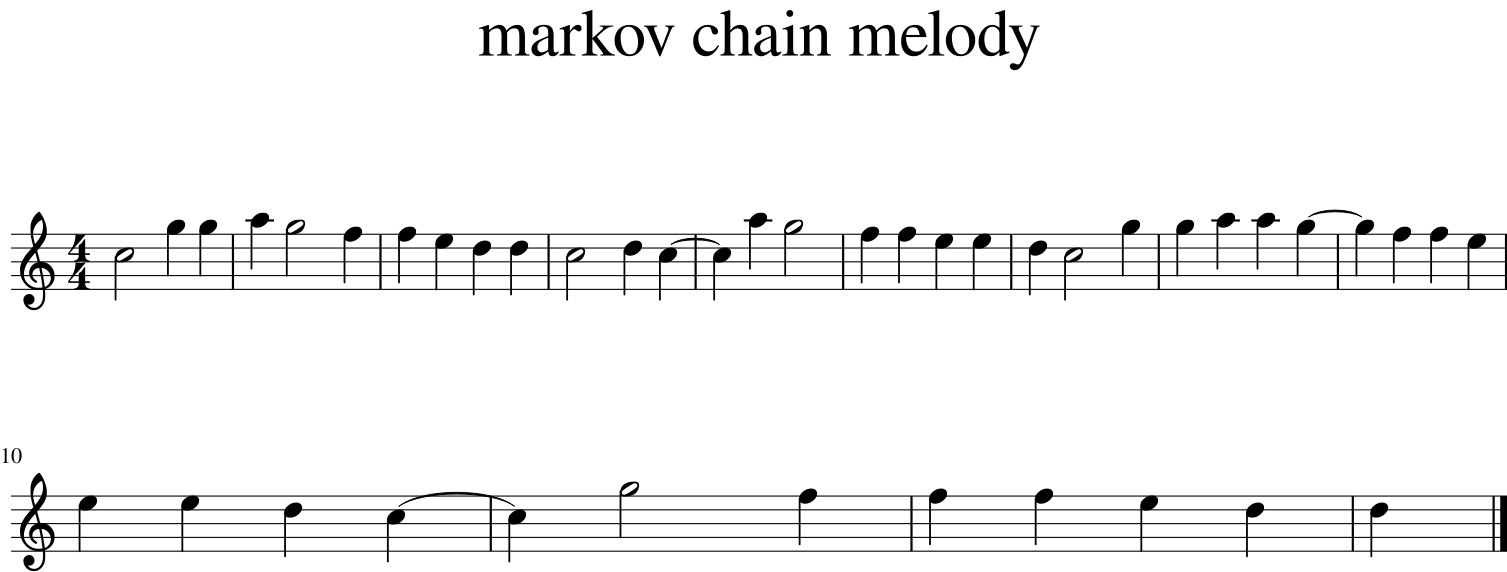

In [ ]:
class MarkovChainMelodyGenerator:
  def __init__(self,states):
    self.states=states #현재 상태
    self.initial_probabilities=np.zeros(len(states))#초기 확률분포
    self.transition_matrix=np.zeros((len(states),len(states)))#전이 확률분포
    self._state_indexes={state:i for (i,state)in enumerate(states)}# 상태를 인덱스로 매핑하는 딕셔너리 생성

  def train(self,notes): #초기 음 확률분포로 지정, 다음 음 확률분포로 지정
    self._calculate_initial_probabilities(notes)
    self._calculate_transition_matrix(notes)

  def generate(self,length):#생성 함수
    melody=[self._generate_starting_state()]
    for _ in range(1,length): #지정된 박자까지 생성
      melody.append(self._generate_next_state(melody[-1])) #하나 끝날때마다 1박씩 줄임
    return melody

  def _calculate_initial_probabilities(self,notes):
    for note in notes: #각 노트에 대해서 실행
      self._increment_initial_probability_count(note)#전체 노트의 초기 확률분포를 확인
    self._normalize_initial_probabilities() #전체 확률분포를 정규화 시켜서 총합을 1로 만듦

  def _increment_initial_probability_count(self,note):
    state=(note.pitch.nameWithOctave,note.duration.quarterLength)#현재 음계, 길이
    self.initial_probabilities[self._state_indexes[state]]+=1 #특정 음계의 확률값을 증가시킴

  def _normalize_initial_probabilities(self): #총 합을 정규화
    total=np.sum(self.initial_probabilities)
    if total:
      self.initial_probabilities/=total
    self.initial_probabilities=np.nan_to_num(self.initial_probabilities)

  def _calculate_transition_matrix(self,notes): #전이 확률분포 계산
    for i in range(len(notes)-1): #훈련셋으로 준 음의 최대 전이 횟수
      self._increment_transition_count(notes[i],notes[i+1])#현재 음, 다음 음의 전이 확률을 각각 증가
    self._normalize_transition_matrix()#모든 확률분포를 정규화

  def _increment_transition_count(self,current_note,next_note):
    state=(
        current_note.pitch.nameWithOctave, #주어진 음
        current_note.duration.quarterLength,# 해당음의 길이
    )
    next_state=(
        next_note.pitch.nameWithOctave, #다음 음
        next_note.duration.quarterLength,# 다음 음의 길이
    )
    self.transition_matrix[ #해당 전이의 횟수를 1회 증가시킴
        self._state_indexes[state], self._state_indexes[next_state]
    ]+=1

  def _normalize_transition_matrix(self):
    row_sums=self.transition_matrix.sum(axis=1)
    with np.errstate(divide="ignore", invalid="ignore"):
      self.transition_matrix=np.where(
          row_sums[:,None], #행의 합이 0이 아닌(이동이 1번이라도 존재했는지) 행에 대해서 정규화
          self.transition_matrix/row_sums[:,None],
          0,
      )

  def _generate_starting_state(self):
    initial_index=np.random.choice( #첫 음 고르기
        list(self._state_indexes.values()),p=self.initial_probabilities
    )
    return self.states[initial_index]

  def _generate_next_state(self,current_state): #현재 음을 가지고 다음 음을 고름
    if self._does_state_have_subsequent(current_state):
      index = np.random.choice( #선택지 중에 1개 고르기, 확률은 현재 음의 전이 매트릭스 안에서 고름
        list(self._state_indexes.values()),
        p=self.transition_matrix[self._state_indexes[current_state]],
      )
      return self.states[index] #전이된 음으로 현재 상태를 업데이트함
    return self._generate_starting_state()

  def _does_state_have_subsequent(self,state):#현재 행이 전이가 가능한지(전이 예제가 있는지) 확인함,
  #총 합이 0보다 크면 어딘가로 이동한다는 것임
    return self.transition_matrix[self._state_indexes[state]].sum()>0

def create_training_data(): #작은별 멜로디로 학습
  return [
        note.Note("C5", quarterLength=1),
        note.Note("C5", quarterLength=1),
        note.Note("G5", quarterLength=1),
        note.Note("G5", quarterLength=1),
        note.Note("A5", quarterLength=1),
        note.Note("A5", quarterLength=1),
        note.Note("G5", quarterLength=2),
        note.Note("F5", quarterLength=1),
        note.Note("F5", quarterLength=1),
        note.Note("E5", quarterLength=1),
        note.Note("E5", quarterLength=1),
        note.Note("D5", quarterLength=1),
        note.Note("D5", quarterLength=1),
        note.Note("C5", quarterLength=2),
    ]

def visualize_melody(melody): #최종 결과 멜로디를 악보로 표현
  print(melody)
  score=stream.Score()
  score.metadata=metadata.Metadata(title="markov chain melody")
  part=stream.Part()
  for n,d in melody:
    part.append(note.Note(n,quarterLength=d))
  score.append(part)
  score.show()

def main():
  training_data=create_training_data()
  states = [
        ("C5", 1),#1인 음은 1박, 2인 음은 2박을 가짐
        ("D5", 1),
        ("E5", 1),
        ("F5", 1),
        ("G5", 1),
        ("A5", 1),
        ("C5", 2),
        ("D5", 2),
        ("E5", 2),
        ("F5", 2),
        ("G5", 2),
        ("A5", 2),
    ]
  model=MarkovChainMelodyGenerator(states)
  model.train(training_data)

  generated_melody=model.generate(40) #총 40박 만듦
  visualize_melody(generated_melody)

if __name__=="__main__":
  main()

